# Ramia_Assignment3

In this project we will use all explanatory variables (with the exception of neighborhood) and all 506 census tract observations from the Boston Housing Study to advise a real estate brokerage firm in its attempt to employ machine learning methods. With the median value of homes in thousands of 1970 dollars as our target variable, we will attempt to assess the market value of residential real estate. We will do so by employing two regression modeling methods: linear regression and ridge regression. We will then evaluate these methods within a cross-validation design, using root mean-squared error (RMSE) as an index of prediction error. Python scikit-learn will be our primary environment for conducting this research. Finally, of the modeling methods examined in our study, we will recommend one to the real estate brokerage firm that we feel has the greatest predictive accuracy.

**Part 1: Data Prep and Exploration**

Seed value for random number generators to obtain reproducible results:

In [1]:
RANDOM_SEED = 1

Although we standardize X and y variables on input, we will fit the intercept term in the models. Expect fitted values to be close to zero.

In [2]:
SET_FIT_INTERCEPT = True

Import base packages into the namespace for this program:

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Import modeling routines from Scikit Learn packages:

In [4]:
import sklearn.linear_model 
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score  
from math import sqrt  # for root mean-squared error calculation

Read data for the Boston Housing Study, creating data frame boston_input:

In [5]:
boston_input = pd.read_csv('boston.csv')

Drop neighborhood from the data being considered:

In [6]:
boston = boston_input.drop('neighborhood', 1)

Check the data:

In [7]:
print('\nFirst 5 Rows of Data:\n')
print(boston.head())

print('\nGeneral Description:\n')
print(boston.info())

print('\nDescriptive Statistics:\n')
print(boston.describe())


First 5 Rows of Data:

      crim    zn  indus  chas    nox  rooms   age     dis  rad  tax  ptratio  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242     17.8   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242     17.8   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222     18.7   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222     18.7   

   lstat    mv  
0   4.98  24.0  
1   9.14  21.6  
2   4.03  34.7  
3   2.94  33.4  
4   5.33  36.2  

General Description of the Data:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
crim       506 non-null float64
zn         506 non-null float64
indus      506 non-null float64
chas       506 non-null int64
nox        506 non-null float64
rooms      506 non-null float64
age        506 non-null float64
dis        506 non-null float64

The max value of our target variable (mv) causes some concern. It appears as though all values greater than $50,000 were truncated. This could cause skewness, with the potential for outliers in the right-hand tail of the distribution. This, of course, is a violation of the assumptions of regression and could result in decreased predictive accuracy and untrustworthy results. One method for dealing with these issues is to log-transform the target variable. We will explore this below:

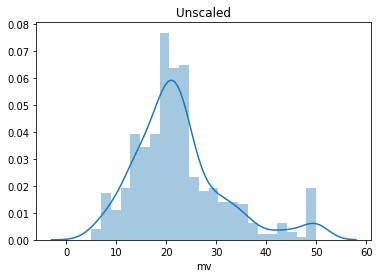

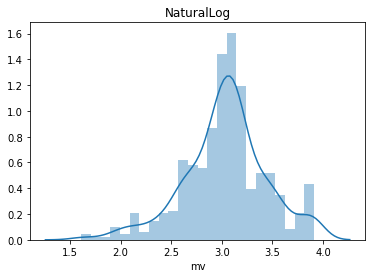

In [8]:
X = boston['mv']
X_log = np.log(X)

sns.distplot(X).set_title('Unscaled')
plt.show()

sns.distplot(X_log).set_title('NaturalLog')
plt.show()

My suspicions were proven correct. The distribution of the unscaled target variable is negatively skewed and spikes at 50. Log transformation appears to assuage these issues, creating a more normally distributed target variable. We will use this as our variable of interest going forward.

In [9]:
boston['log_mv'] = np.log(boston['mv'])

Set up preliminary data for fitting the models. The first column is the log median housing value response. The remaining columns are the explanatory variables.

In [10]:
prelim_model_data = np.array([boston.log_mv,\
    boston.crim,\
    boston.zn,\
    boston.indus,\
    boston.chas,\
    boston.nox,\
    boston.rooms,\
    boston.age,\
    boston.dis,\
    boston.rad,\
    boston.tax,\
    boston.ptratio,\
    boston.lstat]).T

The model data will be a standardized form of the preliminary model data. Standard scalers subtract the mean value (so standardized values always have a zero mean), and then it divides by the standard deviation so that the resulting distribution has unit variance.

It is important to transform the data so that all attributes are on a common scale (e.g. using a standard scaler) before performing Ridge Regression, as it is sensitive to the scale of the input features. This is true of most regularized models.

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

model_data = scaler.fit_transform(prelim_model_data)

**Part 2: Model Evaluation**

Specify the set of regression models being evaluated. Here we will explore two regression models: linear regression and ridge regression.

We chose ridge regression over similar regularized regression methods such as lasso and ElasticNet. In practice, ridge regression is usually the first choice between these three models. Lasso and ElasticNet have their benefits but ridge regression is usually the widely regarded default.

Further, the ridge model makes a trade-off between the simplicity of the model and its performance on the training set. How much importance the model places on simplicity versus training set performance can be specified by the user, using the alpha parameter. The default parameter alpha=1, however, the optimum setting of alpha depends on the particular dataset we are using. Increasing alpha forces coefficients to move more toward zero, which decreases training set performance but might help generalization. Decreasing alpha allows the coefficients to be less restricted, and we end up with a model that resembles linear regression. However, this is at the cost of generalizability. Here we will test a few values of alpha (0.1, 1, and 10) to see which one is optimal for this dataset.

Finally, we set normalize=False because we have standardized the model input data outside of the modeling method calls.

In [13]:
names = ['Linear_Regression', 'Ridge_Regression', 'Ridge10_Regression', 'Ridge01_Regression']

regressors = [LinearRegression(fit_intercept = SET_FIT_INTERCEPT,
                               normalize = False), 
              Ridge(alpha = 1, solver = 'cholesky',
                    fit_intercept = SET_FIT_INTERCEPT,
                    normalize = False,
                    random_state = RANDOM_SEED),
              Ridge(alpha = 10, solver = 'cholesky',
                    fit_intercept = SET_FIT_INTERCEPT,
                    normalize = False,
                    random_state = RANDOM_SEED),
              Ridge(alpha = 0.1, solver = 'cholesky',
                    fit_intercept = SET_FIT_INTERCEPT,
                    normalize = False,
                    random_state = RANDOM_SEED)
             ]

Specify the k-fold cross-validation design:

In [14]:
from sklearn.model_selection import KFold

Ten-fold cross-validation is employed here.

In [15]:
N_FOLDS = 10

Set up numpy array for storing results.

In [16]:
cv_results = np.zeros((N_FOLDS, len(names)))

kf = KFold(n_splits = N_FOLDS, shuffle=False, random_state = RANDOM_SEED)

Check the splitting process by looking at fold observation counts:

The structure of modeling data for this study has the response variable coming first and explanatory variables later so 1:model_data.shape[1] slices for explanatory variables and 0 is the index for the response variable.

For the sake of brevity, I've suppressed the "print" statements below. I've left these in as comments, however, if you are interested in seeing the results for each fold of the following cross-validation.

In [17]:
index_for_fold = 0  # fold count initialized 
for train_index, test_index in kf.split(model_data):
#     print('\nFold index:', index_for_fold,
#           '------------------------------------------')
    X_train = model_data[train_index, 1:model_data.shape[1]]
    X_test = model_data[test_index, 1:model_data.shape[1]]
    y_train = model_data[train_index, 0]
    y_test = model_data[test_index, 0]   
#     print('\nShape of input data for this fold:',
#           '\nData Set: (Observations, Variables)')
#     print('X_train:', X_train.shape)
#     print('X_test:',X_test.shape)
#     print('y_train:', y_train.shape)
#     print('y_test:',y_test.shape)
    
    index_for_method = 0  # initialize
    for name, reg_model in zip(names, regressors):
#         print('\nRegression model evaluation for:', name)
#         print('  Scikit Learn method:', reg_model)
        reg_model.fit(X_train, y_train)  # fit on the train set for this fold
#         print('Fitted regression intercept:', reg_model.intercept_)
#         print('Fitted regression coefficients:', reg_model.coef_)
 
        # evaluate on the test set for this fold
        y_test_predict = reg_model.predict(X_test)
#         print('Coefficient of determination (R-squared):',
#               r2_score(y_test, y_test_predict))
        fold_method_result = sqrt(mean_squared_error(y_test, y_test_predict))
#         print(reg_model.get_params(deep=True))
#         print('Root mean-squared error:', fold_method_result)
        cv_results[index_for_fold, index_for_method] = fold_method_result
        index_for_method += 1
  
    index_for_fold += 1

cv_results_df = pd.DataFrame(cv_results)
cv_results_df.columns = names

In [18]:
print('\n----------------------------------------------')
print('Average results from ', N_FOLDS, '-fold cross-validation\n',
      'in standardized units (mean 0, standard deviation 1)\n',
      '\nMethod               Root mean-squared error', sep = '')     
print(cv_results_df.mean())


----------------------------------------------
Average results from 10-fold cross-validation
in standardized units (mean 0, standard deviation 1)

Method               Root mean-squared error
Linear_Regression     0.496452
Ridge_Regression      0.495693
Ridge10_Regression    0.490730
Ridge01_Regression    0.496374
dtype: float64


Based on the results of the 10-fold cross-validation, it appears as though the ridge regression model with an alpha of 10 provides the lowest root mean squared error (RMSE) among all of the models tested. This model is able to predict the target variable (log_mv) within 0.49 standard deviations, on average.

All models perform somewhat similarly. I would venture that the high-alpha ridge model performed best on the test data because of it's greater generalizability. While this can prevent overfitting, it would be ideal to select a model that finds the right balance between performance on the training set and performance on the test set. For now, I believe I would feel comfortable recommending this model to the real estate brokerage firm. Future studies should explore a spectrum of alpha values, as well as polynomial regression models.